In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
#import seaborn as sns
from hmmlearn.hmm import GMMHMM
from tqdm import tqdm

In [2]:
import seaborn as sns

In [3]:
pca = pd.read_csv("../../data/pca_5c.csv",index_col=0)
pca.index = pd.to_datetime(pca.index)
pca = pca.sort_index()
pca['contago_next'] = pca['contago'].shift(-1)
pca['status_change'] = np.where(pca['contago'] != pca['contago_next'], 1,0)

Text(0.5, 0.98, 'PCA with contango or not')

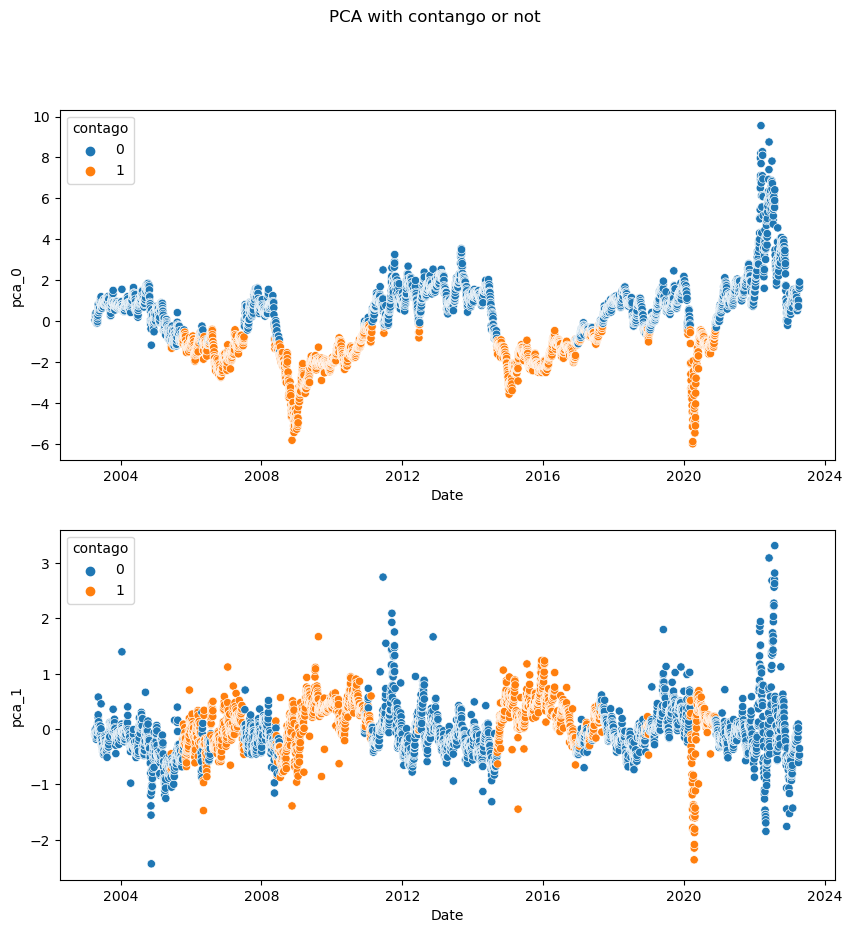

In [5]:
fig,ax = plt.subplots(2,1,figsize=(10,10))
sns.scatterplot(y=pca["pca_0"], x = pca.index, hue = pca["contago"], ax = ax[0])
sns.scatterplot(y=pca["pca_1"], x = pca.index, hue = pca["contago"], ax = ax[1])
plt.suptitle("PCA with contango or not")

Text(0.5, 0.98, 'PCA with status_change(instant)')

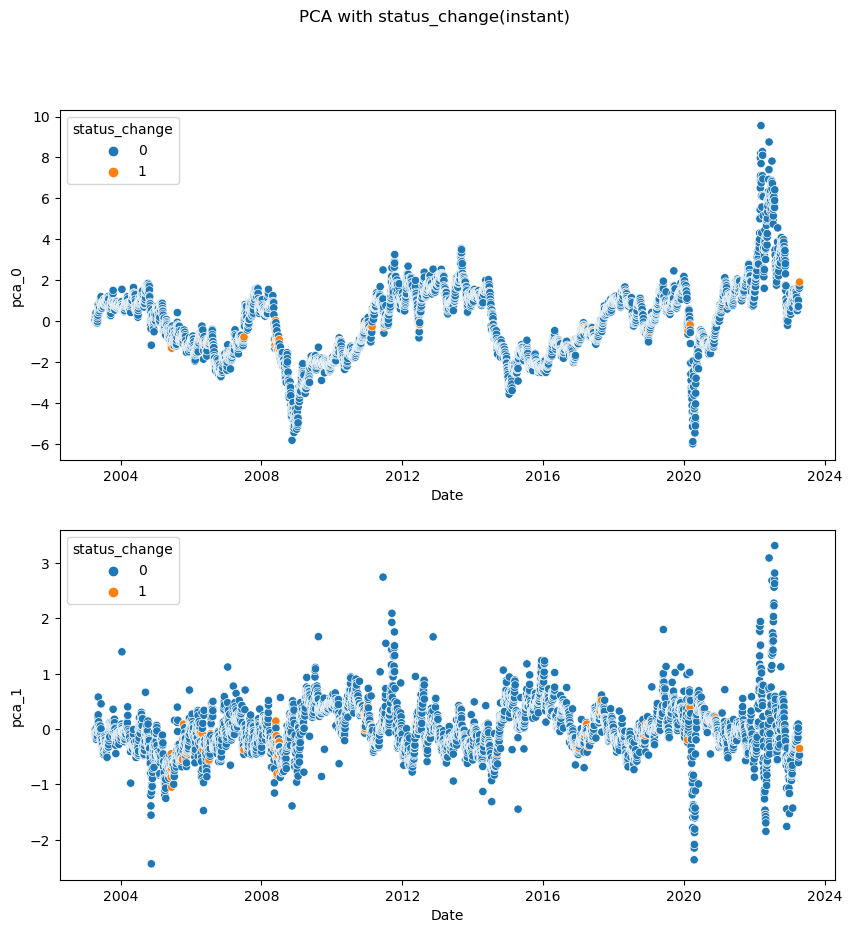

In [10]:
fig,ax = plt.subplots(2,1,figsize=(10,10))
sns.scatterplot(y=pca["pca_0"], x = pca.index, hue = pca["status_change"], ax = ax[0])
sns.scatterplot(y=pca["pca_1"], x = pca.index, hue = pca["status_change"], ax = ax[1])
plt.suptitle("PCA with status_change(instant)")

In [11]:
X = pca[["pca_0","pca_1"]]

In [12]:
def train_hmm(data):
    hmm = GMMHMM(n_components=2,n_mix = 3, covariance_type="full")
    hmm.fit(data);
    return hmm

def best_model(data,n=5):
    hmm_list = [train_hmm(data) for i in range(n)]
    aic_list=[model.aic(data) for model in hmm_list]
    return hmm_list[np.argmin(aic_list)]

def sum_off_diagonal(A):
    return np.sum(A)- np.trace(A)

In [67]:
result_all={}
for t in tqdm(X[X.index>"2008-02"].index):
    result_t={}
    Xt= X[X.index<=t]
    try:
        hmm_model = best_model(Xt,n=10)
    #get result
        A_60 = np.linalg.matrix_power(hmm_model.transmat_,60)
        A_30 = np.linalg.matrix_power(hmm_model.transmat_,30)
        A_10 = np.linalg.matrix_power(hmm_model.transmat_,10)
        A_5 = np.linalg.matrix_power(hmm_model.transmat_,5)
        for k,v in {"5day":A_5,"10day":A_10,"30day":A_30,"60day":A_60}.items():
            result_t[f"start_{k}"] = v[0,1]
            result_t[f"end_{k}"] = v[1,0]
            result_t[f"start_end_{k}"] = sum_off_diagonal(v)
        result_all[t] = result_t
    except:
#         result_all[t] = np.nan
        print (f"Err for {t}")

 42%|██████████████████████████████████████████████████████▉                                                                           | 1657/3922 [1:04:12<1:09:26,  1.84s/it]/Users/ashish1610dhiman/opt/anaconda3/envs/comp_stats_project/lib/python3.9/site-packages/hmmlearn/hmm.py:791: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
 42%|███████████████████████████████████████████████████████▊                                                                            | 1658/3922 [1:04:12<52:20,  1.39s/it]

Err for 2014-07-04 00:00:00


 63%|██████████████████████████████████████████████████████████████████████████████████▊                                                 | 2461/3922 [1:33:07<54:21,  2.23s/it]Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #2 has a null eigenvalue.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3922/3922 [2:38:12<00:00,  2.42s/it]


In [68]:
result_df = pd.DataFrame.from_dict(result_all).T

In [169]:
result_df1 = result_df.merge(pca,left_index=True,right_index=True)

In [70]:
result_df1.to_csv("../../data/hmm_result_transition_prob_v1.csv")

<AxesSubplot: >

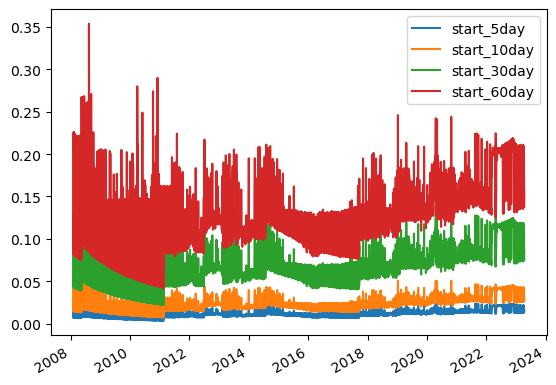

In [163]:
result_df1[["start_5day","start_10day","start_30day","start_60day"]].plot()

### Gen results

In [253]:
result_df1 = result_df.merge(pca,left_index=True,right_index=True)

In [256]:
check_start = pd.Series(result_df1[result_df1["contago"].diff() > 0].index)
start_dates = check_start[(check_start.diff().dt.days>120) | (check_start.index==0)]

check_end = pd.Series(result_df1[result_df1["contago"].diff() < 0].index)
end_dates = check_end[check_end.diff().dt.days>90 | (check_end.index==0)]

check_start_end = pd.Series(result_df1[result_df1["contago"].diff().isin([+1,-1])].index)
start_end_dates = check_start_end[(check_start_end.diff().dt.days>180) | (check_start_end.index==0)]

Text(0.5, 1.0, 'Start/End Tag')

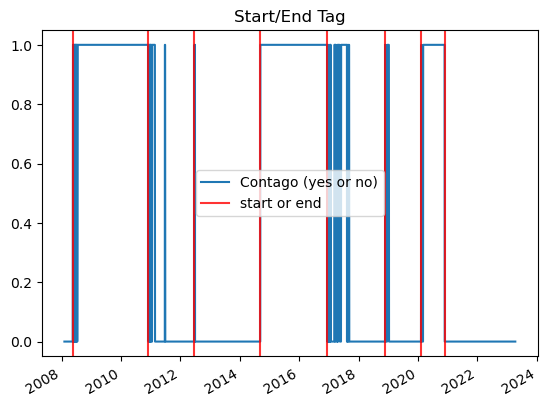

In [257]:
ax = result_df1["contago"].plot(label = "Contago (yes or no)")
for i,start_t in enumerate(start_end_dates):
    if i==len(start_end_dates)-1:
        ax.axvline(start_t, color = "red", alpha = 0.8, label = "start or end")
    else:
        ax.axvline(start_t, color = "red", alpha = 0.8)
ax.legend()
ax.set_title("Start/End Tag")

In [258]:
start_dates

0    2008-05-19
11   2010-12-08
17   2011-06-24
18   2012-06-20
20   2014-09-10
21   2016-12-14
32   2018-11-23
35   2020-02-10
dtype: datetime64[ns]

Text(0.5, 1.0, 'Start Tag')

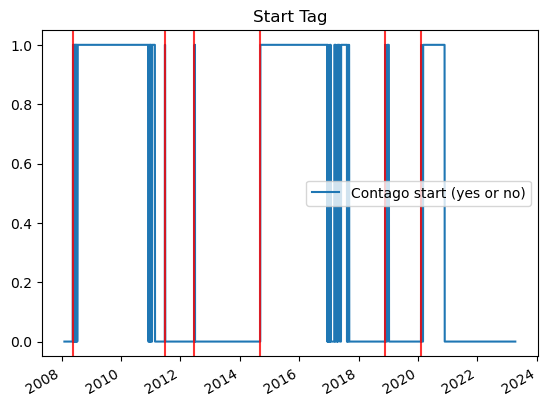

In [260]:
ax = result_df1["contago"].plot(label = "Contago start (yes or no)")
for i,start_t in enumerate(start_dates.drop([11,21])):
    if i==len(start_end_dates)-1:
        ax.axvline(start_t, color = "red", alpha = 0.8, label = "start")
    else:
        ax.axvline(start_t, color = "red", alpha = 0.8)
ax.legend()
ax.set_title("Start Tag")

Text(0.5, 1.0, 'Start Tag')

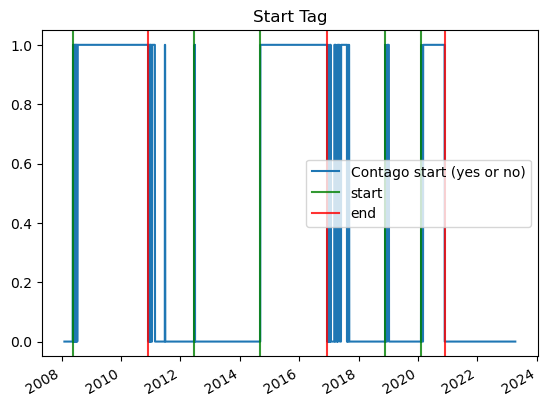

In [265]:
ax = result_df1["contago"].plot(label = "Contago start (yes or no)")
start_dates2 = start_dates.drop([11,21])
for i,start_t in enumerate(start_end_dates):
    color_t = "green" if start_t in start_dates2.values else "red"
    label_t = "start" if start_t in start_dates2.values else "end"
#     print (color_t)
    if i==len(start_end_dates)-1 or i==0:
        ax.axvline(start_t, color = color_t, alpha = 0.8, label = label_t)
    else:
        ax.axvline(start_t, color = color_t, alpha = 0.8)
ax.legend()
ax.set_title("Start Tag")

In [266]:
prob_cols = [c for c in result_df1.columns if "day" in c]
ma_cols = []
for c in prob_cols:
    for ma_days in [5,10,20,150,300]:
        result_df1[f"{c}_ma{ma_days}_days"] = result_df1[c].rolling(ma_days).mean()
        ma_cols.append(f"{c}_ma{ma_days}_days")

In [267]:
result_df1["shape_change_clean"] = (result_df1.index.isin(start_end_dates)).astype("int")
result_df1["contango_start_clean"] = (result_df1.index.isin(start_dates)).astype("int")
result_df1["contango_end_clean"] = (result_df1.index.isin(\
                                                         set(start_end_dates)-set(start_dates.drop([11,21])))).astype("int")

### Create start signal

In [274]:
result_df1.groupby("contango_start_clean")[[c for c in result_df1.columns if "start_5day_" in c\
                                         ]].mean()

,start_5day_ma5_days,start_5day_ma10_days,start_5day_ma20_days,start_5day_ma150_days,start_5day_ma300_days
contango_start_clean,,,,,
0,0.012439,0.012435,0.012430,0.012326,0.012120
1,0.012280,0.011903,0.011644,0.011064,0.011006


In [278]:
(0.012280/0.011064)/(0.012439/0.012326)

1.0998232473530845

In [276]:
result_df1.groupby("contango_start_clean")[[c for c in result_df1.columns if "start_10day_" in c\
                                         ]].mean()

,start_10day_ma5_days,start_10day_ma10_days,start_10day_ma20_days,start_10day_ma150_days,start_10day_ma300_days
contango_start_clean,,,,,
0,0.024542,0.024534,0.024525,0.024325,0.023927
1,0.024236,0.023494,0.022993,0.021871,0.021758


In [279]:
(0.024236/0.021871)/(0.024542/0.024325)

1.0983359538869506

In [462]:
result_df1["trade_start"] = ((result_df1["start_10day_ma5_days"]/result_df1["start_10day_ma150_days"])>1.3).astype("int")

### End Signal

In [391]:
result_df1.groupby("contango_end_clean")[[c for c in result_df1.columns if "end_10day_" in c\
                                         ]].mean()

,end_10day_ma5_days,end_10day_ma10_days,end_10day_ma20_days,end_10day_ma150_days,end_10day_ma300_days,start_end_10day_ma5_days,start_end_10day_ma10_days,start_end_10day_ma20_days,start_end_10day_ma150_days,start_end_10day_ma300_days
contango_end_clean,,,,,,,,,,
0,0.024481,0.024471,0.024459,0.024237,0.023818,0.049022,0.049005,0.048982,0.048559,0.047742
1,0.020368,0.020549,0.020587,0.022278,0.022118,0.045243,0.044198,0.043966,0.044582,0.044405


In [392]:
0.022278/0.020368

1.0937745483110761

In [469]:
result_df1["trade_end"] = ((result_df1["end_10day_ma150_days"]/result_df1["end_10day_ma5_days"])>1.16).astype("int")

Text(0.5, 1.0, 'Jump in 5 day MA near Contango Start')

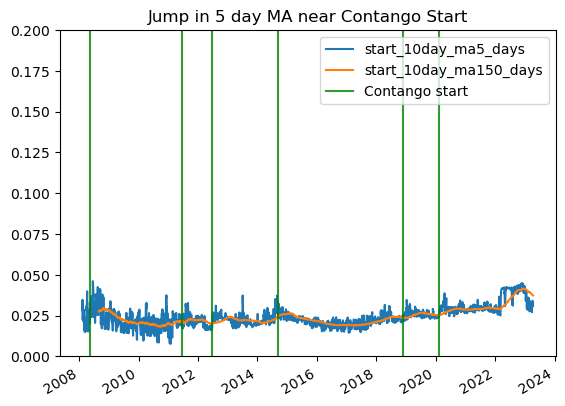

In [494]:
ax = result_df1[["start_10day_ma5_days","start_10day_ma150_days"]].plot()
# (result_df1["end_10day_ma150_days"]/result_df1["end_10day_ma5_days"]).plot(ax=ax)
start_dates2 = start_dates.drop([11,21])
for i,start_t in enumerate(start_dates2):
    color_t = "green" if start_t in start_dates2.values else "red"
    label_t = "Contango start" if start_t in start_dates2.values else "end"
#     print (color_t)
    if i==len(start_end_dates)-1 or i==0:
        ax.axvline(start_t, color = color_t, alpha = 0.8, label = label_t)
    else:
        ax.axvline(start_t, color = color_t, alpha = 0.8)
ax.legend()
ax.set_ylim(0.0,0.2)
ax.set_title("Jump in 5 day MA near Contango Start")

In [ ]:
ax = result_df1[["end_10day_ma150_days","end_10day_ma5_days"]].plot()
# (result_df1["end_10day_ma150_days"]/result_df1["end_10day_ma5_days"]).plot(ax=ax)
start_dates2 = start_dates.drop([11,21])
for i,start_t in enumerate(start_dates2):
    color_t = "green" if start_t in start_dates2.values else "red"
    label_t = "Contango start" if start_t in start_dates2.values else "end"
#     print (color_t)
    if i==len(start_end_dates)-1 or i==0:
        ax.axvline(start_t, color = color_t, alpha = 0.8, label = label_t)
    else:
        ax.axvline(start_t, color = color_t, alpha = 0.8)
ax.legend()
ax.set_ylim(0.0,0.2)
ax.set_title("Jump in 5 day MA near Contango Start")

Text(0.5, 1.0, 'Jump in MA ratio near Contango End')

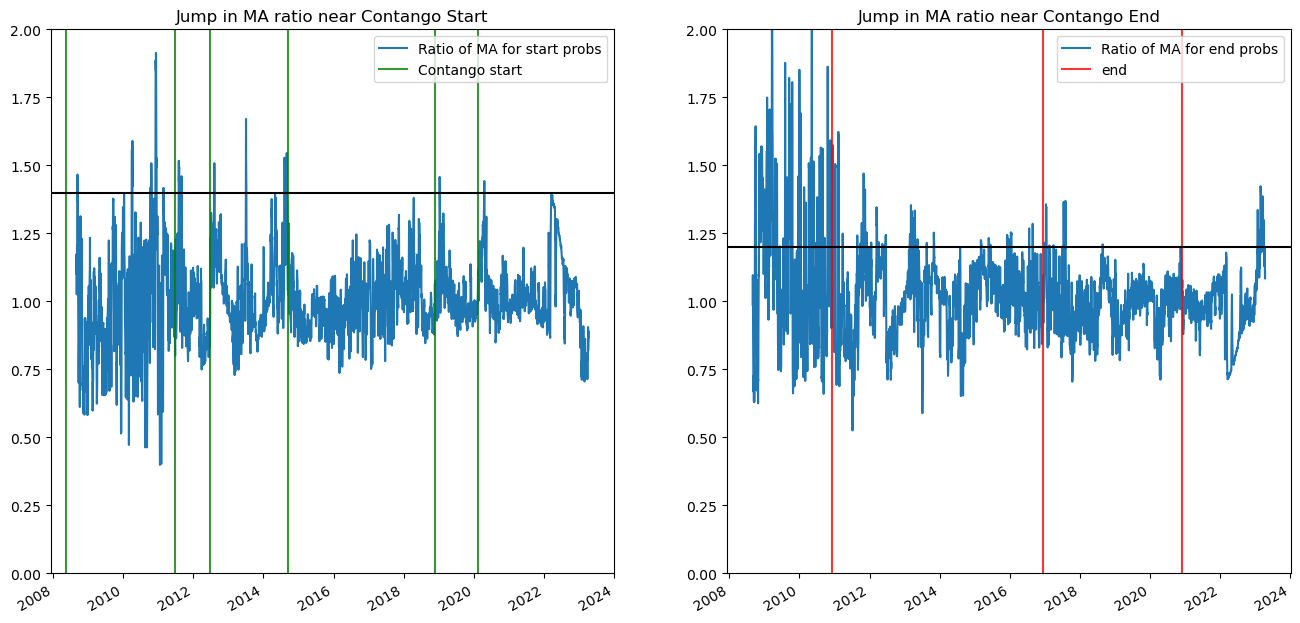

In [506]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

(result_df1["start_10day_ma5_days"]/result_df1["start_10day_ma150_days"]\
).plot(label="Ratio of MA for start probs",ax=ax[0])
# (result_df1["end_10day_ma150_days"]/result_df1["end_10day_ma5_days"]).plot(ax=ax)
start_dates2 = start_dates.drop([11,21])
for i,start_t in enumerate(start_dates2):
    color_t = "green" if start_t in start_dates2.values else "red"
    label_t = "Contango start" if start_t in start_dates2.values else "end"
#     print (color_t)
    if i==len(start_end_dates)-1 or i==0:
        ax[0].axvline(start_t, color = color_t, alpha = 0.8, label = label_t)
    else:
        ax[0].axvline(start_t, color = color_t, alpha = 0.8)
ax[0].legend()
ax[0].axhline(1.4,color="black")
ax[0].set_ylim(0.0,2.0)
ax[0].set_title("Jump in MA ratio near Contango Start")

(result_df1["end_10day_ma150_days"]/result_df1["end_10day_ma5_days"]\
).plot(label="Ratio of MA for end probs",ax=ax[1])
# (result_df1["end_10day_ma150_days"]/result_df1["end_10day_ma5_days"]).plot(ax=ax)
start_dates2 = start_dates.drop([11,21])
for i,start_t in enumerate(start_end_dates):
    if start_t not in start_dates2.values:
        color_t = "green" if start_t in start_dates2.values else "red"
        label_t = "Contango start" if start_t in start_dates2.values else "end"
#     print (color_t)
        if i==len(start_end_dates)-1 or i==0:
            ax[1].axvline(start_t, color = color_t, alpha = 0.8, label = label_t)
        else:
            ax[1].axvline(start_t, color = color_t, alpha = 0.8)
ax[1].legend()
ax[1].axhline(1.2,color="black")
ax[1].set_ylim(0.0,2.0)
ax[1].set_title("Jump in MA ratio near Contango End")

In [ ]:
result_df1["trade_start"] = ((result_df1["start_10day_ma5_days"]/result_df1["start_10day_ma150_days"]\
                             )>1.3).astype("int")
result_df1["trade_end"] = ((result_df1["end_10day_ma150_days"]/result_df1["end_10day_ma5_days"]\
                           )>1.4).astype("int")

### Check signal

Text(0.5, 1.0, 'Predicted Start/End Tag')

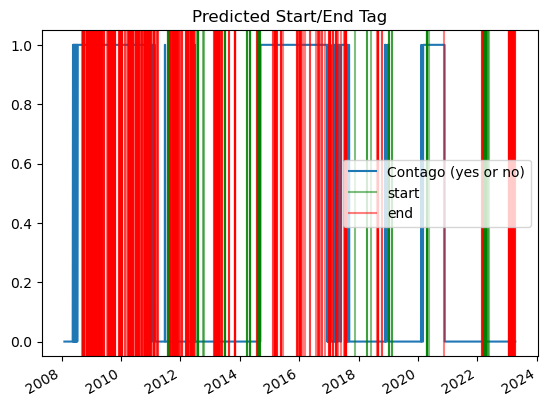

In [470]:
ax = result_df1["contago"].plot(label = "Contago (yes or no)")

pred_start = result_df1[result_df1["trade_start"]>0].index
pred_end = result_df1[result_df1["trade_end"]>0].index

for i,start_t in enumerate(pred_start):
    if i==len(pred_start)-1:
        ax.axvline(start_t, color = "green", alpha = 0.5, label = "start")
    else:
        ax.axvline(start_t, color = "green", alpha = 0.5)
        
for i,end_t in enumerate(pred_end):
    if i==len(pred_end)-1:
        ax.axvline(end_t, color = "red", alpha = 0.5, label = "end")
    else:
        ax.axvline(end_t, color = "red", alpha = 0.5)
        
ax.legend()
ax.set_title("Predicted Start/End Tag")

In [480]:
GAP_START_END = 280 
GAP_END_START = 365
GAP_START_START = 30

pred_start_dates=[]
pred_end_dates=[]
first_start = True
first_end = True
last_insert =""

for t,s,e in zip(result_df1.index,result_df1["trade_start"],result_df1["trade_end"]):
    if s>0 and e==0:
        if first_start:
            pred_start_dates.append(t)
            last_insert ="start"
            first_start = False
        elif not first_end and last_insert == "end":
            if (t-pred_end_dates[-1]).days>=GAP_END_START & (t-pred_start_dates[-1]).days>=GAP_START_START:
                pred_start_dates.append(t)
                last_insert ="start"
    if e>0 and s==0 and last_insert=="start":
        if (t-pred_start_dates[-1]).days>=GAP_START_END:
            pred_end_dates.append(t) 
            last_insert="end"
            first_end = False
        

In [481]:
pred_start_dates,pred_end_dates

([Timestamp('2008-09-12 00:00:00'),
  Timestamp('2010-04-01 00:00:00'),
  Timestamp('2012-07-06 00:00:00'),
  Timestamp('2014-03-26 00:00:00'),
  Timestamp('2017-11-13 00:00:00'),
  Timestamp('2020-04-15 00:00:00')],
 [Timestamp('2009-07-17 00:00:00'),
  Timestamp('2011-01-06 00:00:00'),
  Timestamp('2013-04-15 00:00:00'),
  Timestamp('2015-02-12 00:00:00'),
  Timestamp('2018-08-23 00:00:00'),
  Timestamp('2022-03-02 00:00:00')])

Text(0.5, 1.0, 'Trading Start/End Signal')

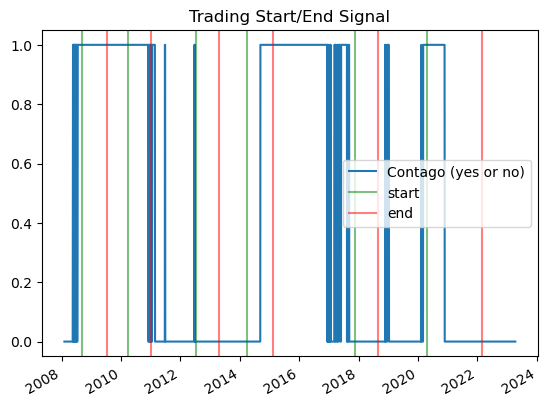

In [482]:
ax = result_df1["contago"].plot(label = "Contago (yes or no)")

# pred_start = result_df1[result_df1["trade_start"]>0].index
# pred_end = result_df1[result_df1["trade_end"]>0].index

for i,start_t in enumerate(pred_start_dates):
    if i==len(pred_start_dates)-1:
        ax.axvline(start_t, color = "green", alpha = 0.5, label = "start")
    else:
        ax.axvline(start_t, color = "green", alpha = 0.5)
        
for i,end_t in enumerate(pred_end_dates):
    if i==len(pred_end_dates)-1:
        ax.axvline(end_t, color = "red", alpha = 0.5, label = "end")
    else:
        ax.axvline(end_t, color = "red", alpha = 0.5)
        
ax.legend()
ax.set_title("Trading Start/End Signal")

In [484]:
result_df1["trade_start_clean"] = (result_df1.index.isin(pred_start_dates)).astype("int")
result_df1["trade_end_clean"] = (result_df1.index.isin(pred_end_dates)).astype("int")

In [485]:
result_df1.to_csv("../../data/hmm_result_transition_prob_and_signals_v1.csv")

In [382]:
# trade_start = pd.Series(result_df1[result_df1["trade_start"].diff() > 0].index)
# pred_start_dates = trade_start[(trade_start.diff().dt.days>90) | (trade_start.index==0)]

# trade_end = pd.Series(result_df1[result_df1["trade_end"].diff() > 0].index)
# pred_end_dates = trade_end[trade_end.diff().dt.days>120 | (trade_end.index==0)]

# # check_start_end = pd.Series(result_df1[result_df1["contago"].diff().isin([+1,-1])].index)
# # start_end_dates = check_start_end[(check_start_end.diff().dt.days>180) | (check_start_end.index==0)]

<AxesSubplot: >

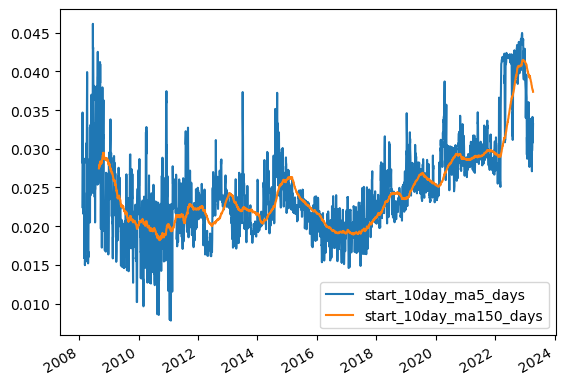

In [325]:
result_df1[["start_10day_ma5_days","start_10day_ma150_days"]].plot()

In [155]:
result_df1["shape_change_clean"]

0.00204029584289722

In [153]:
result_df1.groupby("shape_change_clean")

<AxesSubplot: >

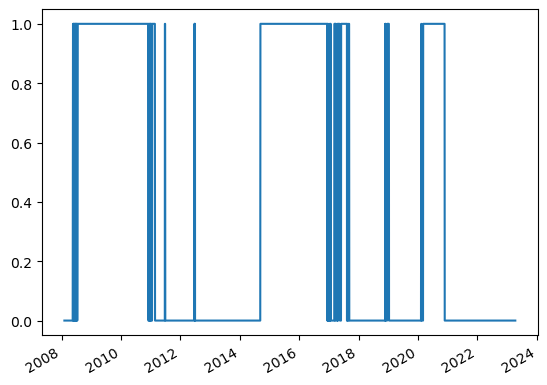

In [88]:
result_df1["contago"].plot()

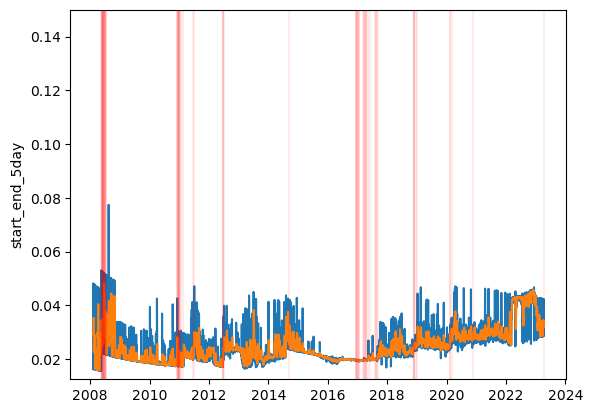

In [83]:
ax = sns.lineplot(x=result_df1.index, y=result_df1["start_end_5day"])
ax.plot(result_df1["start_end_5day"].rolling(5).mean())
ax.set_ylim(top=0.15)
for i in result_df1[result_df1.status_change>0.0].index:
    ax.axvline(i,color="red",alpha=0.08)

In [72]:
start_dates

11   2010-12-08
17   2011-06-24
18   2012-06-20
20   2014-09-10
21   2016-12-14
32   2018-11-23
35   2020-02-10
dtype: datetime64[ns]